In [1]:
import pandas as pd
import datascience as ds
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

Load in the California Housing Data 

In [27]:
# Load Scikit-Learn's housing dataset
housing = fetch_california_housing(as_frame=True)

# Load the dataset into Pandas data frame
df = pd.DataFrame(housing.data, columns=housing.feature_names) # Dataset features
df["MedHouseVal"] = housing.target # Response

# Load the dataset into Datascience table
housing_table = ds.Table.from_df(df)
housing_table.show(10)

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
8.3252,41,6.98413,1.02381,322,2.55556,37.88,-122.23,4.526
8.3014,21,6.23814,0.97188,2401,2.10984,37.86,-122.22,3.585
7.2574,52,8.28814,1.07345,496,2.80226,37.85,-122.24,3.521
5.6431,52,5.81735,1.07306,558,2.54795,37.85,-122.25,3.413
3.8462,52,6.28185,1.08108,565,2.18147,37.85,-122.25,3.422
4.0368,52,4.76166,1.10363,413,2.1399,37.85,-122.25,2.697
3.6591,52,4.93191,0.951362,1094,2.1284,37.84,-122.25,2.992
3.12,52,4.79753,1.06182,1157,1.78825,37.84,-122.25,2.414
2.0804,42,4.29412,1.11765,1206,2.02689,37.84,-122.26,2.267
3.6912,52,4.97059,0.990196,1551,2.17227,37.84,-122.25,2.611


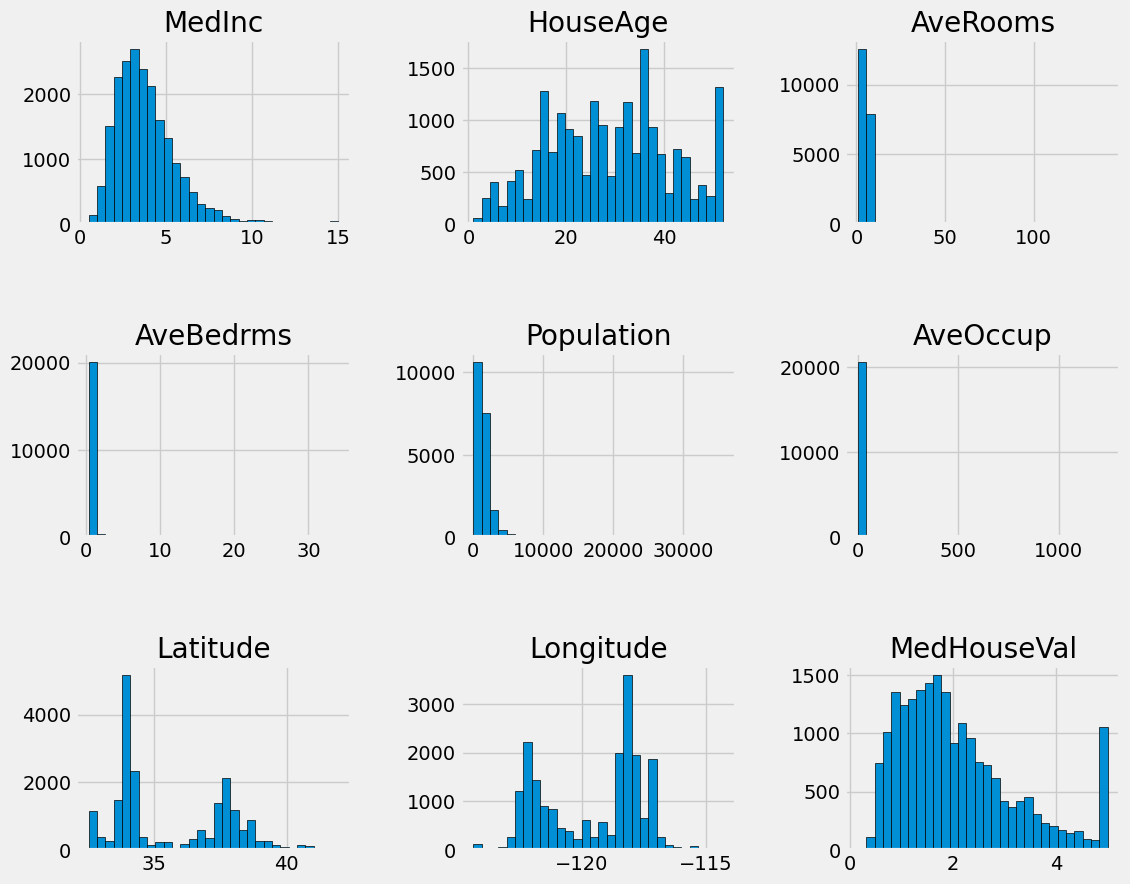

In [26]:
housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.savefig("data_dist.png", dpi=100)

Split the data into training and testing

In [3]:
# Set seed to get consistent results
seed = 100

# Predictors
X = df.drop("MedHouseVal", axis=1)
# Response - Median House Value
Y = df["MedHouseVal"]

In [4]:
# test_size=0.2 - 20% of data is used for testing and not training
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Create a decision tree regressor class
model = DecisionTreeRegressor(max_depth=5, random_state=seed)

# Train the model on different maximum depths (distance from root node to the leaf nodes)
# Try different max_depths (1 - 20)
for depth in np.arange(1, 21, 1):
    model = DecisionTreeRegressor(max_depth=depth, random_state=seed)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Depth: {depth}, R²: {r2_score(y_test, y_pred):.4f}, MSE: {mse:.4f}")

# No maximum depth specified
model = DecisionTreeRegressor(random_state=seed)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Depth: {model.get_depth()}, R²: {r2_score(y_test, y_pred):.4f}, MSE: {mse:.4f}")

Depth: 1, R²: 0.3105, MSE: 0.9290
Depth: 2, R²: 0.4578, MSE: 0.7306
Depth: 3, R²: 0.5365, MSE: 0.6245
Depth: 4, R²: 0.5841, MSE: 0.5604
Depth: 5, R²: 0.6316, MSE: 0.4964
Depth: 6, R²: 0.6677, MSE: 0.4478
Depth: 7, R²: 0.6871, MSE: 0.4217
Depth: 8, R²: 0.7118, MSE: 0.3883
Depth: 9, R²: 0.7156, MSE: 0.3832
Depth: 10, R²: 0.7018, MSE: 0.4018
Depth: 11, R²: 0.6960, MSE: 0.4096
Depth: 12, R²: 0.6896, MSE: 0.4182
Depth: 13, R²: 0.6850, MSE: 0.4245
Depth: 14, R²: 0.6724, MSE: 0.4414
Depth: 15, R²: 0.6505, MSE: 0.4709
Depth: 16, R²: 0.6514, MSE: 0.4697
Depth: 17, R²: 0.6596, MSE: 0.4586
Depth: 18, R²: 0.6574, MSE: 0.4617
Depth: 19, R²: 0.6485, MSE: 0.4737
Depth: 20, R²: 0.6330, MSE: 0.4944
Depth: 34, R²: 0.6432, MSE: 0.4808


Train model

In [5]:
model = DecisionTreeRegressor(max_depth=9, random_state=seed)
model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=9, random_state=100)

Plot Decision Tree

In [ ]:
# DO NOT TRY AND DISPLAY THE DECISION TREE - IT WILL TIMEOUT
plt.figure(figsize=(200, 100))
plot_tree(
    model,
    feature_names=housing.feature_name,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.savefig("decision_tree.svg", dpi=500)
plt.close()

Look at Feature Importance

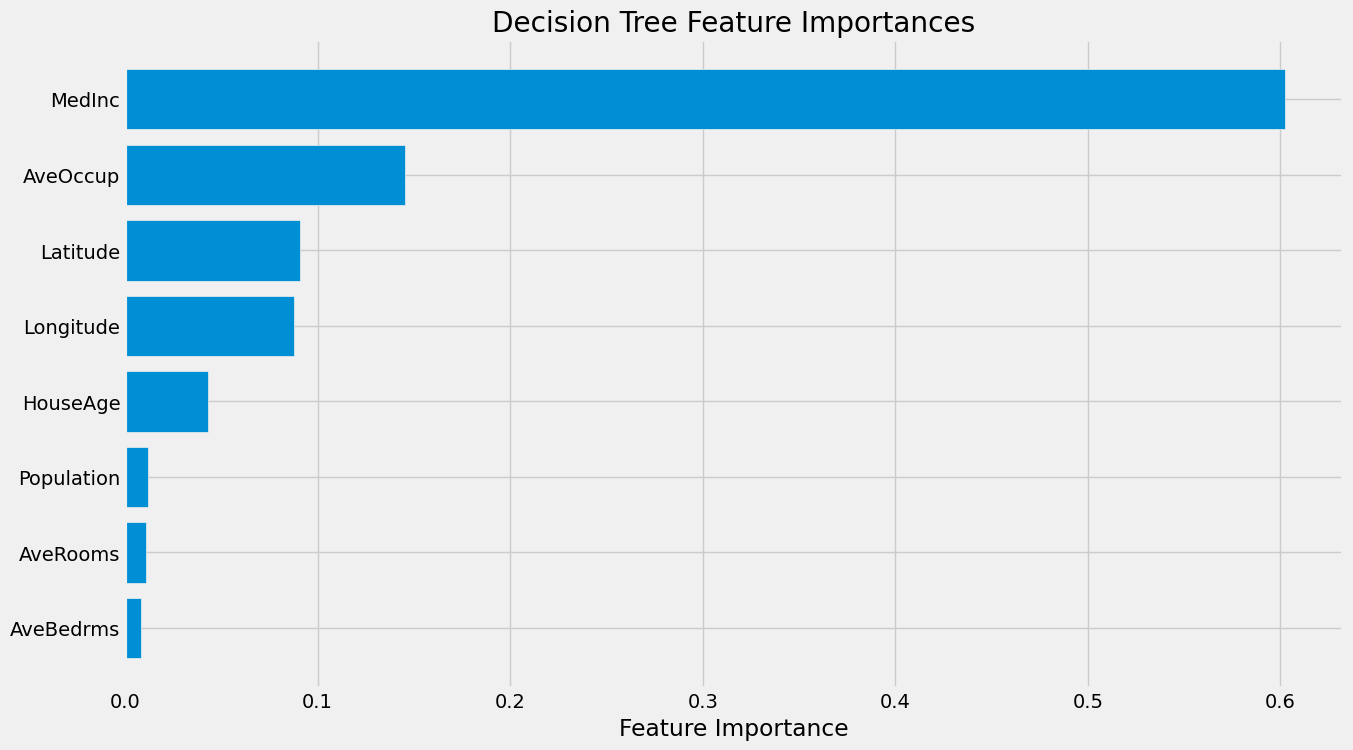

,Feature,Importance
0,MedInc,0.602449
5,AveOccup,0.145135
6,Latitude,0.090724
7,Longitude,0.087511
1,HouseAge,0.043260
4,Population,0.011863
2,AveRooms,0.010903
3,AveBedrms,0.008154


In [11]:
importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Feature Importance")
plt.title("Decision Tree Feature Importances")
plt.gca().invert_yaxis()
plt.savefig("feature_importance.png", dpi=100)
plt.show()

importance_df

In [ ]:
for feature in X.columns:
    sorted_idx = X[feature].argsort()
    x_vals = X[feature].values[sorted_idx]
    y_vals = Y.values[sorted_idx]

    X_line = pd.DataFrame(np.tile(X.mean().values, (len(x_vals), 1)), columns=X.columns)
    X_line[feature] = x_vals

    y_line = model.predict(X_line)

    plt.figure(figsize=(8, 5))
    plt.scatter(x_vals, y_vals, alpha=0.3, label="Actual", color="gray")
    plt.plot(x_vals, y_line, color="red", linewidth=2, label="Model Prediction")
    plt.xlabel(feature)
    plt.ylabel("Median House Value")
    plt.title(f"{feature} vs. Median House Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

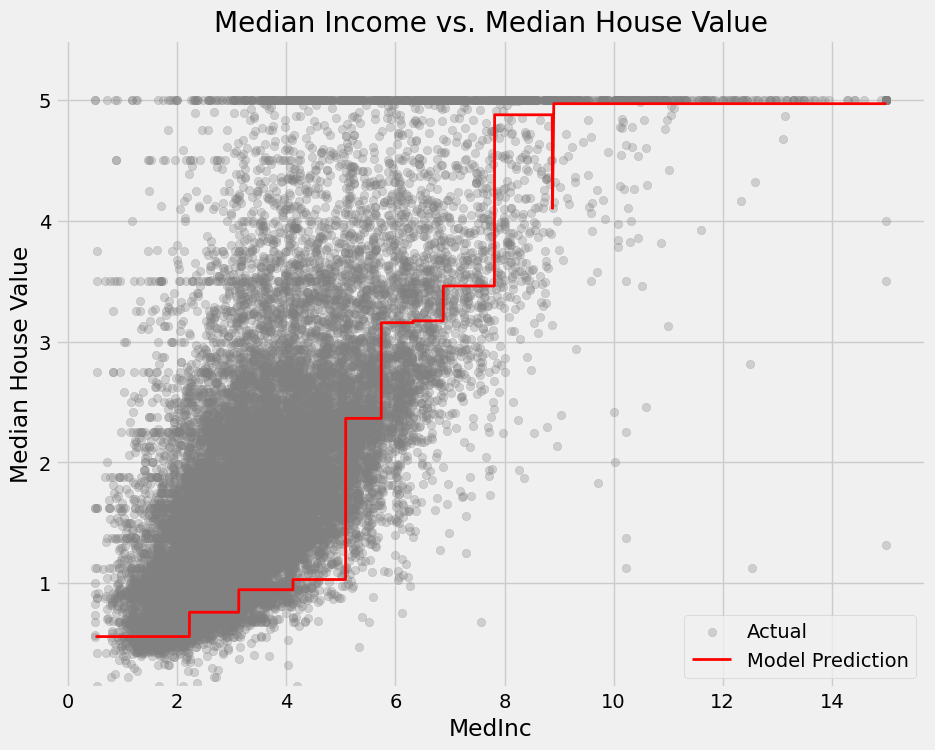

In [28]:
feature = "MedInc"
sorted_idx = X[feature].argsort()
x_vals = X[feature].values[sorted_idx]
y_vals = Y.values[sorted_idx]
X_line = pd.DataFrame(np.tile(X.mean().values, (len(x_vals), 1)), columns=X.columns)
X_line[feature] = x_vals

y_line = model.predict(X_line)

plt.figure(figsize=(10, 8))
plt.scatter(x_vals, y_vals, alpha=0.3, label="Actual", color="gray")
plt.plot(x_vals, y_line, color="red", linewidth=2, label="Model Prediction")
plt.xlabel(feature)
plt.ylabel("Median House Value")
plt.ylim(bottom=min(y_vals) * 0.9, top=max(y_vals) * 1.1)
plt.title("Median Income vs. Median House Value")
plt.legend()
plt.savefig(f"{feature}vsMedHouseVal.png", dpi=100)
plt.show()